In [3]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
import astropy
from astropy.time import Time
import matplotlib.pyplot as plt

In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
event = Time("2013-02-15 03:20:21.1", format="iso", scale="utc")
aa_frame = AltAz(location=EarthLocation(lat=54.4540*u.deg,lon= 64.4739*u.deg), obstime=event)
up = SkyCoord('0deg 90deg',frame=aa_frame, unit=u.deg).transform_to("icrs")
east = SkyCoord('90deg 0deg',frame=aa_frame, unit=u.deg).transform_to("icrs")
ura, udec = up.ra.value, up.dec.value
era, edec = east.ra.value, east.dec.value

In [29]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])
    
def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

def run(params):
    randfac = 0.
    sim = rebound.Simulation.from_file("ss_frame.bin")
    #sim.Nactive = sim.N
    p = sim.particles[3].copy()
    p.m = 0.

    #Relative velocity to atmosphere 
    v = (19.03+0.13*randfac*np.random.normal())*0.033572943
    vx, vy, vz = -v*radec2xyz(328.12+0.10*randfac*np.random.normal(),7.41+0.05*randfac*np.random.normal())
    p.vx += vx; p.vy += vy; p.vz += vz    
    
    #atmosphere velocity relative to Earth
    vx, vy, vz = +0.27411473*0.033572943*radec2xyz(era,edec)
    p.vx += vx; p.vy += vy; p.vz += vz

    #Location + 95km
    r = 4.2587571e-05 + 6.3503578e-07
    x, y, z = r*radec2xyz(ura, udec)
    p.x += x; p.y += y; p.z += z    

    sim.add(p)
    sim.move_to_com()
    sim.ri_ias15.min_dt = 1e-6
    
    
    N=100000
    samples = np.zeros((N,3))
    times = np.linspace(0.,-1e5,N)
    for i,t in enumerate(times):
        sim.integrate(t)
        samples[i] = [sim.particles[8].x, sim.particles[8].y, sim.particles[8].z]
    
    return samples


In [30]:
samples = run(1)

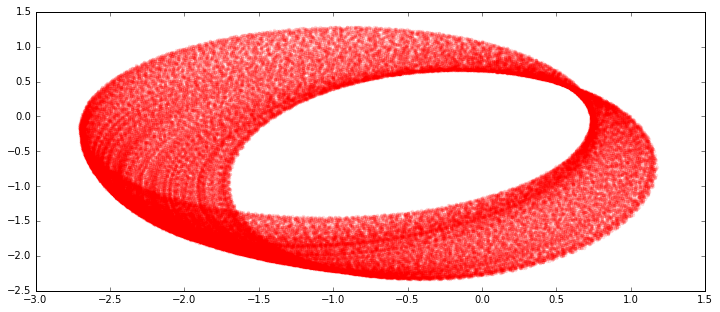

In [31]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(samples[:,0],samples[:,1],"r.",alpha=0.1)

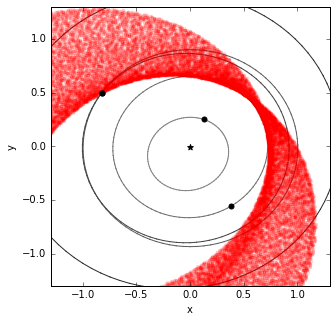

In [39]:
sim = rebound.Simulation.from_file("ss_frame.bin")
f = rebound.OrbitPlot(sim,lim=1.3);
f.axes[0].plot(samples[:,0],samples[:,1],"r.",alpha=0.1)

In [32]:
print(1)

1
